In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from google.colab import files
files.upload()
# choose the file on your computer to upload it then
#import data

Saving get_data.py to get_data (1).py


{'get_data.py': b"import os\nimport numpy as np\nimport tensorflow as tf\n\nfrom skimage.transform import resize\nfrom sklearn.model_selection import train_test_split\n\n\ndef get_dataset(which='colab', test_size=0.1, val_size=0.1, random_state=69):\n\n\n    BATCH_SIZE = 128\n    im_height = 256\n    im_width = 256\n\n    # Set data location\n    if (which=='colab'):\n        print('Google Drive folder')\n        training_path = 'drive/My Drive/training.nosync'\n    else:\n        print('Local folder')\n        training_path = 'training.nosync'\n    img_name = 'image.npy'\n    gt_name = 'gt.npy'\n\n    # Set fraction to use as test and validation\n    test_size = 0.1\n    val_size = 0.1\n\n    max_slices = 15\n\n    walk = next(os.walk(training_path))[1]\n\n    X = np.zeros((len(walk)*max_slices, im_height, im_width, 1))\n    y = np.zeros((len(walk)*max_slices, im_height, im_width, 1))\n\n    img_nr = 0\n    sum_slices = 0\n    patients_not_found = 0\n    for ids in walk:\n\n        tr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
import tensorflow as tf
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import BSpline
from cv2 import floodFill

from spline import Spline
from network import get_model, convNet
from get_data import get_dataset, get_raw_dataset
from utils import iou

from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [5]:
if 'COLAB_TPU_ADDR' not in os.environ: 
  print('Not connected to TPU') 
else: 
  print("Connected to TPU") 

Connected to TPU


In [6]:
model = convNet(16, 256, 256)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       7

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, termcolor, numpy, protobuf, opt-einsum, scipy, absl-py, google-pasta, six, astunparse, keras-preprocessing, wheel, grpcio, gast, tensorboard, wrapt, tensorflow-estimator
Required-by: fancyimpute


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### Generate Data

In [7]:
train_dataset, valid_dataset, test_dataset = get_dataset(which='colab', val_size=0.1, random_state=69)



Google Drive folder
0 images and 9 slices loaded to array
10 images and 94 slices loaded to array
20 images and 185 slices loaded to array
30 images and 277 slices loaded to array
patient090 not found
40 images and 374 slices loaded to array
50 images and 470 slices loaded to array
60 images and 556 slices loaded to array
70 images and 668 slices loaded to array
80 images and 773 slices loaded to array
90 images and 869 slices loaded to array
Image load complete. 99 images and 944 slices loaded successfully. 
(944, 256, 256, 1) (944, 256, 256, 1)
[0. 1.]
Training size: 764, Validation size: 85, Test size: 95


In [ ]:
checkpoint_path = 'weights_1.h5'
model_path = 'model_1.h5'

### Help Functions

In [ ]:


def calc_intersect(point):
    #cell_height = point[1]-int(point[1])
    #return cell_height*255.0
    return 255.0


def calc_stepsize(nd, d, p_i, delta_t):
    """
    Based on theroretical estimate, see report
    """
    #return 1.0/((nd+d)*np.max(np.sum(p_i, axis=0)))
    return delta_t/(np.sum(np.sqrt(np.sum(np.square(p_i), axis=1))))
    


def floodFill_start(img, row):
    """
    Should be cleaned
    """
    """
    Iterates outwards from start row to find point satisfied by
    ray-casting algortihm to be inside spline
    """
    if (row >= 256 or row < 0):
        return False
    next_row = int(row + 10)
    intersect = np.where(img[row, :] > 0.0)[0]
    nr_intersect = intersect.shape[0]
    if (nr_intersect > 0):
        if (intersect[0] > 0):
            return (0, row)
        else:
            for i in range (0, nr_intersect-2, 2):
                if (intersect[i+2]-intersect[i+1] > 1):
                    return (int((intersect[i+1]+intersect[i])/2), row)
        return floodFill_start(img, next_row)
    else:
        return floodFill_start(img, next_row)
    
    
def floodFill_(img):
    img = np.pad(img, 1, 'constant', constant_values=(0))
    start_ind = floodFill_start(img, 0)
    if not start_ind:
        img[:,:] = 0
    else:
        img = img.astype('uint8')
        img = floodFill(img, None, start_ind, 1.0)[1]
        cond = np.where((img==0) | (img==1))
        img[cond] = 1-img[cond]
    img = img.astype('float32')
    img[np.where(img > 1)] = img[np.where(img > 1)]/255.0
    img = img[1:-1, 1:-1]
    return img


def get_spline_img(p, batch_size, n):
    #time_start = time.time()
    d = 3
    nd = n+d
    rows = 256
    cols = 256
    
    img_batch = np.zeros((batch_size, rows, cols))
    
    # Iterate over all examples of batch
    for i in range(batch_size):
        p_i = p[i, :].reshape(n, 2)
        p_temp = np.zeros((nd,2))
        p_temp[:n] = p_i
        p_temp[n:] = p_i[:d]
        p_i = p_temp

        t = np.linspace(0, 1, nd+d+1)
        delta_t = 1/(nd+d)
        spline = BSpline.construct_fast(t, p_i, d, 'periodic')

        # Calculate step size
        step = calc_stepsize(nd, d, p_i, delta_t)
        
        # Calculate spline
        img = np.zeros((rows, cols))
        t_n = np.linspace(0, 1, int(1.0/step))
        for x in t_n:
            point = spline(x)
            col = int(point[0])
            row = int(point[1])
            if img[row, col] == 0:
                img[row, col] = calc_intersect(point)
        
        # Flood fill spline
        img_batch[i, :, :] = floodFill_(img)

    return img_batch

In [ ]:
def seg_loss(labels, predictions, p, axis=0):
    beta = 0.01
    bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    ce = tf.reduce_sum(bce(labels, predictions), axis=axis)
    #reg = beta * tf.reduce_sum(tf.math.square(tf.abs(p-(256.0/2))), axis=1)
    reg = tf.keras.losses.MSE(256.0/2, p)
    reg = tf.cast(reg, dtype='float32')
    return tf.math.add(ce, beta*reg)
    #return reg

                               
@tf.custom_gradient
def spline_loss(labels, predictions):
    
    labels = tf.squeeze(labels)
    p = predictions.numpy() # Transform input tensor to numpy-array
    batch_size, output_size = p.shape[0], p.shape[1]
    n = int(output_size/2)  # n is number of control points
    
    # Calculate batch loss
    predictions = tf.constant(get_spline_img(p, batch_size, n), dtype='float32')  # Draw spline from control points
    predictions = tf.squeeze(predictions)
    assert predictions.numpy()[np.where(predictions.numpy()>1)].size == 0
    loss = seg_loss(labels, predictions, p, axis=1)
    
    # Custom gradient for spline loss
    def spline_grad(dLoss, dPred):
        
        difference = 'central'
        dP = 1.0
        gradient = np.zeros((batch_size, output_size))
        #ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
        
        # Iterate over all samples in batch
        for sample in range(batch_size):
            
            # Kan NONE FJERNES? UNØDVENDIG DIM
            p_sample = p[None, sample, :].copy()
            
             # Iterate over all control points to calculate gradient
            for i in range(output_size):
                
                dP_ = np.zeros((1, output_size))
                dP_[:,i] = dP
                
                
                #Forward/backward difference approximation to gradient
                if (difference == 'forward'):
                    
                    # Check if point close to boundary
                    if (p_sample[:, i] + dP < 256.0/2):
                        sign = 1
                    else:
                        sign = -1

                    p_dP = p_sample + sign*dP_
                    img = get_spline_img(p_dP, 1, n)

                    # MÅ FJERNES HVIS VEKTORISERING
                    img = np.squeeze(img)
                    assert img[np.where(img>1)].size == 0

                    loss_dP = seg_loss(labels[sample, :, :], tf.constant(img, dtype='float32'), p_dP, axis=0)
                    gradient[sample, i] = sign*(loss_dP - loss[sample])/dP
                
                
                # Central difference approximation to gradient
                elif (difference == 'central'):
                    
                    if (p_sample[:, i] + dP < 256.0):
                        p_dp_forw = p_sample + dP_
                    else:
                        p_dp_forw = p_sample
                        
                    if (p_sample[:, i] - dP >= 0.0):
                        p_dp_back = p_sample - dP_
                    else:
                        p_dp_back = p_sample
                        
                    img_forw = get_spline_img(p_dp_forw, 1, n)
                    img_back = get_spline_img(p_dp_back, 1, n)
                    
                    img_forw = np.squeeze(img_forw)
                    assert img_forw[np.where(img_forw>1)].size == 0
                    img_back = np.squeeze(img_back)
                    assert img_back[np.where(img_back>1)].size == 0
                    
                    loss_dP_forw = seg_loss(labels[sample, :, :], tf.constant(img_forw, dtype='float32'), p_dp_forw, axis=0)
                    loss_dP_back = seg_loss(labels[sample, :, :], tf.constant(img_back, dtype='float32'), p_dp_back, axis=0)
                    gradient[sample, i] = (loss_dP_forw - loss_dP_back) / (2*dP)
                    
                    
                #ta = ta.write(sample, sign*(loss_dP - loss[sample])/dP)
                """
                if (i%8==0):
                    print('control points: ', p_sample)
                    print('Gradient: ', gradient[sample, i])
                    plt.figure()
                    plt.imshow(predictions[sample, :, :])
                    plt.show()
                """
                
        gradient = tf.constant(gradient, dtype='float32')
        #gradient = ta
        #print(gradient)
        return None, gradient

    return (loss, predictions), spline_grad
    
    
@tf.custom_gradient    
def spline_loss_test(labels, predictions):
    
    #loss =  beta * tf.reduce_sum(tf.math.square(tf.abs(p-(256.0/2))), axis=1)
    loss = tf.keras.losses.MSE(256.0/2, predictions)
    #loss = tf.cast(loss, dtype='float32')
    
    def grad_fn(dLab):
        grad = -2*(256.0/2 - predictions)
        #grad = tf.cast(grad, dtype='float32')
        return None, grad
    
    return loss, grad_fn
    #return loss
    

# Train the model
#@tf.function # Speeds things up
# https://www.tensorflow.org/tutorials/customization/performance
def model_train(features, labels):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        
        # Get the probabilities
        predictions = 255.9*model(features, training=True)

        # Calculate the loss
        loss, predictions = spline_loss(labels, predictions)
        #loss = spline_loss_test(labels, predictions)

    # Get the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    
    # Update the weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update the loss and accuracy
    labels = tf.squeeze(labels)
    train_loss(loss)
    train_iou(labels, predictions)
    

def model_validate(features, labels):
    predictions = 255.9*model(features, training=False)
    v_loss, predictions = spline_loss(labels, predictions)
    labels = tf.squeeze(labels)
    valid_loss(v_loss)
    valid_iou(labels, predictions)



### Model

### Train

In [ ]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="train_iou")
valid_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="valid_iou")

In [ ]:
best_loss = 99999
num_epochs = 60

# Train the model for num_epochs
for epoch in range(num_epochs):
    
    # Run the model through train and validation sets respectively
    for (features, labels) in train_dataset:
        model_train(features, labels)
    
    
    for valid_features, valid_labels in valid_dataset:
        model_validate(valid_features, valid_labels)
        
    
    # Grab the results
    (loss, iou) = train_loss.result(), train_iou.result()
    #loss = train_loss.result()
    (val_loss, val_iou) = valid_loss.result(), valid_iou.result()

    # Clear the current state of the metrics
    train_loss.reset_states(), train_iou.reset_states()
    valid_loss.reset_states(), valid_iou.reset_states()
    
    #print(f'Epoch: {epoch}, Loss: {loss}')
    
    # Local logging
    
    template = "Epoch {}, loss: {:.3f}, iou: {:.3f}, val_loss: {:.3f}, val_iou: {:.3f}"
    print (template.format(epoch+1,
                        loss,
                        iou,
                        val_loss,
                        val_iou))
    
    if (val_loss < best_loss):
        best_loss = val_loss
        model.save_weights('model.h5')
        print(f'New low val_loss. Model weights saved.')

    model.save('colab1_epoch'+str(epoch))
        
        
    # Logging with W&B
    """
    wandb.log({"train_loss": loss.numpy(),
              "train_accuracy": acc.numpy(),
              "val_loss": val_loss.numpy(),
              "val_accuracy": val_acc.numpy()
    })
    get_sample_predictions() # More on this later
    """

Epoch 1, loss: 433.256, iou: 0.520, val_loss: 175.035, val_iou: 0.620
New low val_loss. Model weights saved.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: colab1_epoch0/assets
Epoch 2, loss: 197.629, iou: 0.566, val_loss: 178.064, val_iou: 0.526
INFO:tensorflow:Assets written to: colab1_epoch1/assets
Epoch 3, loss: 190.989, iou: 0.599, val_loss: 189.266, val_iou: 0.489
INFO:tensorflow:Assets written to: colab1_epoch2/assets
Epoch 4, loss: 196.282, iou: 0.582, val_loss: 190.546, val_iou: 0.490
INFO:tensorflow:Assets written to: colab1_epoch3/assets
Epoch 5, loss: 189.590, iou: 0.558, val_loss: 247.630, val_iou: 0.671
INFO:tensorflow:Assets written to: colab1_epoch4/assets
Epoch 6, loss: 197.888, iou: 0.626, val_loss: 185.355, val_iou: 0.506
INFO:tensorflow:Assets written to: colab1_epoch5/assets
Epoch 7, loss: 181.339, iou: 0.611, val_loss: 189.038, val_iou: 0.502
INFO:tensorflow:Assets written to: colab1_epoch6/asset

In [ ]:
model.save('colab1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: colab1/assets


In [ ]:
!zip -r /content/file.zip /content/colab1

  adding: content/colab1/ (stored 0%)
  adding: content/colab1/saved_model.pb (deflated 91%)
  adding: content/colab1/assets/ (stored 0%)
  adding: content/colab1/variables/ (stored 0%)
  adding: content/colab1/variables/variables.index (deflated 55%)
  adding: content/colab1/variables/variables.data-00000-of-00001 (deflated 7%)


### Evaluate

[0.33877456 0.38818607 0.39782855 0.4030691  0.40885472 0.41224194
 0.41232866 0.41848627 0.42018968 0.4430095  0.45258883 0.4532796
 0.45670137 0.45972478 0.46673796 0.4790098  0.479227   0.48296556
 0.48407167 0.48463652 0.48806503 0.48832327 0.48921683 0.491038
 0.49206692 0.49285597 0.4937117  0.49569395 0.49784938 0.49883184
 0.49893823 0.49968386 0.5049194  0.5080964  0.50833666 0.50842637
 0.5115003  0.5142239  0.51446015 0.5150351  0.5161547  0.51727074
 0.5179535  0.5181016  0.5212381  0.52347183 0.52718    0.52779603
 0.52821875 0.5285993  0.52898574 0.53040314 0.53147626 0.5318173
 0.5369281  0.53805065 0.5512929  0.5557447  0.5568729  0.5623254
 0.5788398  0.5900296  0.6140905  0.66932213]
[0.4937117  0.41848627 0.42018968 0.46673796 0.479227   0.52779603
 0.51446015 0.5161547  0.5179535  0.5049194  0.5142239  0.49285597
 0.48921683 0.5115003  0.5369281  0.52347183]


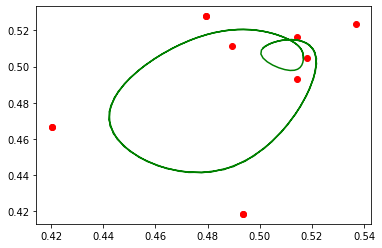

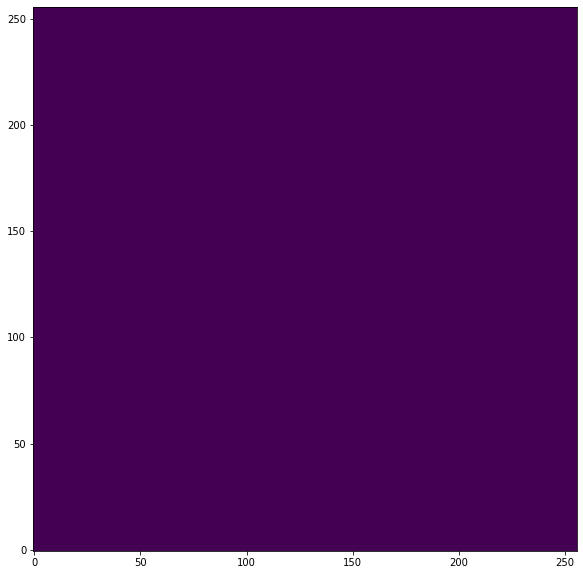

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
preds = model.predict(test_dataset)
print(np.unique(preds))

i = 2

print(preds[i, :])

spline = Spline(preds[i, :])
spline.drawCurve()
spline.get_spline(flood=True)

In [ ]:
preds = model.predict(X_test)
print(np.unique(preds))

print(preds[0, :])

spline = Spline(preds[0, :])
spline.drawCurve()
spline.get_spline(flood=True)

In [ ]:
plt.imshow(np.squeeze(y_test[1,:]))

In [ ]:
a = preds[None, 1, :].copy()
print(a.shape)

valid_acc(y_test[1,:], get_spline_img(preds[None, 1, :], 1, 8))

In [ ]:
preds[1, :]

In [ ]:
a = np.ones(5)
a[0] = 0
a[1] = 0.2
a[2] = 10
b = np.zeros(5)
bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
print(bce(a,b))
assert a[np.where(a>1)].size == 0

In [ ]:
model.layers[10].get_weights()

In [ ]:
p = np.ones((2, 10))
pd = tf.reduce_sum(tf.abs(p-256/2), axis=1)
pd.dtype

In [ ]:
### VISUALIZATION

In [59]:
def plot_sample_one_model(X, y, savename='cardiacmri.pdf', ix=None):
    
    plt.rcParams.update({'font.size': 18})

    # Create ground truth masks
    y_mask = y.copy()
    y_mask = np.ma.masked_where(y_mask < 0.5, y_mask)
    
    
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 2, figsize=(13, 13))
    
    # Turn off tick labels
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
  
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    #ax[0].imshow(preds_mask[ix, ..., 0], cmap='prism', interpolation='none', alpha=0.6)
    #if has_mask:
        #ax[0].contour(preds[ix].squeeze(), colors='y', levels=[0.5])
    ax[0].set_title('Cardiac MRI-image')
    
    #ax[1].imshow(y[ix].squeeze())
    #ax[1].set_title('Ground truth mask')
    
    
    ax[1].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[1].imshow(y_mask[ix].squeeze(), cmap='prism', interpolation='none', alpha=0.6)
    ax[1].set_title('Ground truth mask');
    
    
    plt.savefig(savename)

In [32]:
X_train, X_test = get_raw_dataset()

Google Drive folder
0 images and 9 slices loaded to array
10 images and 94 slices loaded to array
20 images and 185 slices loaded to array
30 images and 277 slices loaded to array
patient090 not found
40 images and 374 slices loaded to array
50 images and 470 slices loaded to array
60 images and 556 slices loaded to array
70 images and 668 slices loaded to array
80 images and 773 slices loaded to array
90 images and 869 slices loaded to array
Image load complete. 99 images and 944 slices loaded successfully. 
(944, 256, 256, 1) (944, 256, 256, 1)
[0. 1.]
Training size: 764, Validation size: 85, Test size: 95


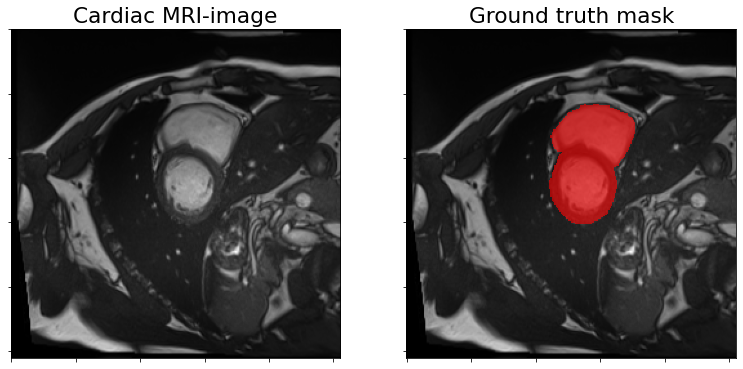

In [61]:
plot_sample_one_model(X_train, X_test, ix=32)